# Project: Seattle Trip Planning using Airbnb

## Section 1: Business Understanding

The goal of this analysis is to help determine the optimum conditions for taking a trip to Seattle, WA.

Specifically it attempts to answer the following 3 questions

1. What’s the best time of year to go in terms of rental availability?
2. How much can I expect to pay for a rental?
3. What factors contribute most significantly to the overall rating for a rental?

## Section 2: Data Understanding
The data consists of 3 datasets downloaded from https://www.kaggle.com/datasets/airbnb/seattle

Import packages and load the 3 datasets

In [1]:
import numpy as np
import pandas as pd
from pandasql import sqldf
import matplotlib as mplib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

listings_df = pd.read_csv('..//Data/listings.csv')
calendar_df = pd.read_csv('..//Data/calendar.csv')
reviews_df = pd.read_csv('..//Data/reviews.csv')

#### Lets look at some of the data in the calendar dataset first

In [2]:
calendar_df.shape

(1393570, 4)

In [3]:
calendar_df.head(5)

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


The calendar dataset has 1,393,570 rows and 4 columns. It can help us answer 2 of our questions about availability and price

+ The listing_id column is a unique identifier for the listing. 
+ The date column contains the date
+ The available column indicates whether the listing was available ("t") or not ("f") on that date
+ The price column indicates the price for the listing on that date

#### Next, lets look at the listings dataset

In [4]:
listings_df.shape

(3818, 92)

In [5]:
listings_df.head(5)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


The listings dataset has 3818 rows and 92 columns. It consists of an identifier for the listing and numerous 
other columns that contain text descriptions along with some numeric characteristics associated with the listing. 
For our analysis we will focus on the "review_scores" columns in this dataset to help answer the 3rd question posed above

### Finally lets take a look at the reviews dataset

In [6]:
reviews_df.shape

(84849, 6)

In [7]:
reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


The reviews dataset contains 84,849 rows and 6 columns. It contains a listing_id, a date, a couple of identifiers
for the reviewer and the comments that the reviewer left about the listing on that date. We won't be working with
this dataset in this analysis but the comments can potentially be used for sentiment analysis in the future.

### Section 3: Data Preparation

In order to determine what time of year has the most available units, convert the date column in the listings 
dataset to a date and extract the month from the date and add it as a separate column to the dataset

In [8]:
# convert the date column to a datetime
# extract the month from the date and add as a separate column
calendar_df['date'] = pd.to_datetime(calendar_df['date'])
calendar_df['month'] = calendar_df['date'].dt.month

In order to determine what prices to expect to pay for a listing we need to clean the 
price column in the listings dataset. The prices contain dollar signs and commas and we
need to convert them to pure numeric fields for further analysis

In [9]:
# remove dollar sign and commas so we can work with price as a numeric field 
calendar_df['price'] = calendar_df['price'].str.replace('$','',regex=False)
calendar_df['price'] = calendar_df['price'].str.replace(',','',regex=False)
calendar_df['price'] = pd.to_numeric(calendar_df['price'])

For our price analysis create a separate dataset that contains only those rows where the price is available

In [10]:
# create a dataframe from the calendar dataframe dropping any rows where 
# the price is null
all_prices_df = calendar_df.dropna(subset=['price'])

In order to determine which specific revier scores are most indicative of the overall score
given by a reviewer, a linear regression model will be fitted. The following steps will be taken
to clean the data in the reviews dataset in preparation for running the model

+ create a new dataframe with only the overall rating and component rating columns
+ drop any rows where all the values are null
+ drop any rows where the overall rating is null because that's the column we're trying to predict
+ fill any missing values with the mean of the value for that column

In [11]:
# prep review columns for linear regression model
review_scores_df = listings_df[['review_scores_rating','review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin','review_scores_communication', 'review_scores_location', 'review_scores_value']]
review_scores_df = review_scores_df.dropna(how='all')
review_scores_df = review_scores_df.dropna(subset=['review_scores_rating'])
review_scores_df = review_scores_df.fillna(review_scores_df.mean())

## Section 4: Modeling
To determine which scores are most indicative of the overall rating run a linear regression
model. The dataset will be split into test and training datasets. The model will be fit
with the training dataset and then the predictive ability of the model will be evaluated 
against the unseen data in the test datasets


In [12]:
# run a linear regression on the dataframe to assign weights to the score components
# run the model with unseen data and see how 
X = review_scores_df[review_scores_df.columns.difference(["review_scores_rating"])]
y = review_scores_df["review_scores_rating"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression() # Instantiate
lm_model.fit(X_train, y_train) #Fit

y_test_preds = lm_model.predict(X_test) 
"The r-squared score for the model using only quantitative variables was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

'The r-squared score for the model using only quantitative variables was 0.6485531047095807 on 952 values.'

The r_squared score for the model is 65% which is acceptable for this analysis

### Section 5: Evaluation

### Question 1. What’s the best time of year to go in terms of rental availability?

In [13]:
# create a dataframe of days where a list was available
available_only_df = calendar_df[calendar_df['available'] == 't']

In [14]:
# use pandasql to group the count of available units by month and display results
# ordered by the largest counts first
query = '''
    select distinct
        month,
        count(*) available_units
    from
        available_only_df
    group by
        month
    order by
        count(*) desc
    '''
available_per_month_df = sqldf(query)
available_per_month_df

,month,available_units
0,12,87061
1,3,83938
2,10,82438
3,11,81780
4,5,79971
5,9,77246
6,6,77244
7,8,76347
8,4,76037
9,7,74222


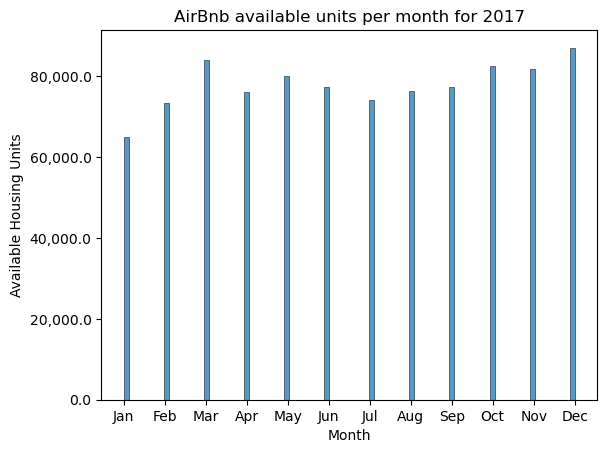

In [15]:
# plot the available units by month to visually represent the information above
fig, ax = plt.subplots()
sns.histplot(data=available_only_df,x='month')
ax.set_xticks(range(1,13,1)) # <--- set the ticks first
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax.get_yaxis().set_major_formatter(mplib.ticker.FuncFormatter(lambda x, p: '{:,}'.format(x)))
dummy = ax.set(xlabel='Month',
       ylabel='Available Housing Units',
       title='AirBnb available units per month for 2017')

plt.savefig('AirBnb available units per month for 2017.png')

#### Although there's plenty of listings available at all times of the year, the table and plot show that December, March, and October are the 3 months with the most available units. In general, the later months in the year have the most available units

### Question 2. How much can I expect to pay for a rental?

In [16]:
# list the min and max prices from the prices dataframe
query = '''
    select 
        max(price),
        min(price)
    from
        all_prices_df
    '''
min_max_price_df = sqldf(query)
min_max_price_df

,max(price),min(price)
0,1650.0,10.0


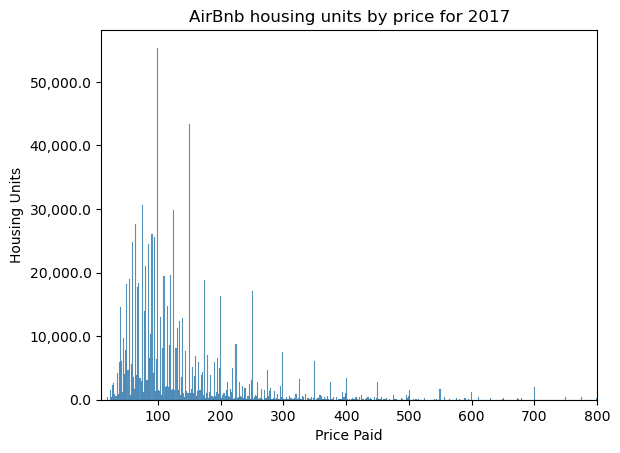

In [17]:
fig, ax = plt.subplots()
sns.histplot(data=all_prices_df,x='price')
ax.set_xlim(10,800)
ax.get_yaxis().set_major_formatter(mplib.ticker.FuncFormatter(lambda x, p: '{:,}'.format(x)))
dummy = ax.set(xlabel='Price Paid',
       ylabel='Housing Units',
       title='AirBnb housing units by price for 2017')
plt.savefig('AirBnb housing units by price for 2017.png')

#### The plot shows the majority of rental units cost between 50 and 200 dollars with 100 dollars being the most frequent price

### Question 3. What factors contribute most significantly to the overall rating for a rental?

Create a function to display the coefficients from the linear model created in Section 4 in descending order of contribution to the prediction of the overall rating for a listing

In [18]:
# define a function to extract the coefficients from the regression model 
# and order them highest to lowest
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
5,review_scores_value,3.058346,3.058346
2,review_scores_cleanliness,2.352576,2.352576
0,review_scores_accuracy,1.526999,1.526999
1,review_scores_checkin,1.294785,1.294785
3,review_scores_communication,1.267077,1.267077
4,review_scores_location,0.533938,0.533938


#### The output indicates that value is the most important quality contributing to the overall score given to a listing followed by cleanliness